# Importing Libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import requests
from io import BytesIO
import base64

In [188]:
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb
%run "Git.ipynb".ipynb

# Importing Data

## Tickers

In [6]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [7]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [9]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [10]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [11]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [12]:
#trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Trade%20History%20Reconstructed.xlsx'
myfile = requests.get(url)
trade_history=pd.read_excel(BytesIO(myfile.content))
price=get_trade_in_usdt(trade_history)

In [13]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [14]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\niroo\AppData\Local\Temp\ipykernel_88052\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [15]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [16]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()

In [17]:
holding=Binance.get_inventory()

In [18]:
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
holding_tickers.append('PAXGUSDT')
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT').round(2)

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.94,4615.93,1.00,-131.89,2430.98,2299.09
OMUSDT,526.32,3228.68,0.70,0.00,2702.36,2702.36
BTCUSDT,601.02,728.65,0.16,3.54,127.63,131.17
SOLUSDT,281.20,223.47,0.05,0.00,-57.74,-57.74
JASMYUSDT,387.46,171.94,0.04,0.00,-215.52,-215.52
ETHUSDT,250.75,132.85,0.03,0.00,-117.90,-117.90
TRXUSDT,76.87,114.94,0.02,-10.72,38.07,27.35
BBUSDT,60.18,14.33,0.00,-39.73,-45.85,-85.58
BNBUSDT,1.14,1.07,0.00,-10.61,-0.07,-10.68
PEPEUSDT,0.00,0.00,0.00,-38.52,-0.00,-38.52


In [19]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining

473

In [20]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [21]:
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [22]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [23]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [24]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [25]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [27]:
position=pd.read_excel('Positions.xlsx',index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')
push_or_update_file(positions,'Positions',repo_owner, repo_name, token, branch='main')

🔁 File exists. Will update (SHA: 26ee6f01afcd3ea83eb220456986ba17f2822725)
✅ File pushed/updated successfully!


In [28]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [29]:
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Quantities.xlsx'
myfile = requests.get(url)
quantities_history=pd.read_excel(BytesIO(myfile.content),index_col=0)
#quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

In [30]:
quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx',index=False)

quantities_tickers=list(quantities.columns)

In [31]:
push_or_update_file(quantities,'Quantities',repo_owner, repo_name, token, branch='main')

🔁 File exists. Will update (SHA: 6e3926699f92d5bdd43cebd60018d5c63d556f68)
✅ File pushed/updated successfully!


In [32]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [33]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [34]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()

for col in quantities:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index]

In [35]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [36]:
# pnl_history['Total']

In [37]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [38]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [39]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [40]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in quantities:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [41]:
pnl_history['Total']

2024-09-23    -242.846960
2024-09-24    -351.229838
2024-09-25    -362.331965
2024-09-26    -276.632747
2024-09-27    -260.113627
                 ...     
2025-03-13    1981.620537
2025-03-14    2010.574081
2025-03-15    2202.769914
2025-03-16    2210.019473
2025-03-17    2485.773076
Name: Total, Length: 176, dtype: float64

In [42]:
daily_pnl=pnl_history['Total']-pnl_history['Total'].shift(1)
daily_pnl

2024-09-23           NaN
2024-09-24   -108.382879
2024-09-25    -11.102127
2024-09-26     85.699217
2024-09-27     16.519121
                 ...    
2025-03-13   -137.783248
2025-03-14     28.953544
2025-03-15    192.195833
2025-03-16      7.249559
2025-03-17    275.753603
Name: Total, Length: 176, dtype: float64

In [43]:
days=0
pnl_timeframe=daily_pnl[-days:]
MtM=Binance.get_inventory().loc['Total']['Price in USDT']
var_amount=np.nanpercentile(pnl_timeframe,5)
var_pct=var_amount/MtM
cvar_amount=pnl_timeframe[pnl_timeframe<var_amount].mean()
cvar_pct=cvar_amount/MtM
var_amount,cvar_amount

(-219.6118751223521, -334.9272908594338)

In [44]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [45]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [46]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [47]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change(fill_method=None))


LDUMAUSDT not retrieved
Total not retrieved


In [48]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [49]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [50]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<Axes: >

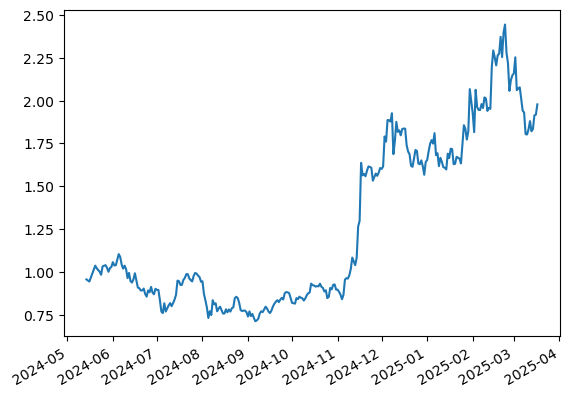

In [51]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

<Axes: >

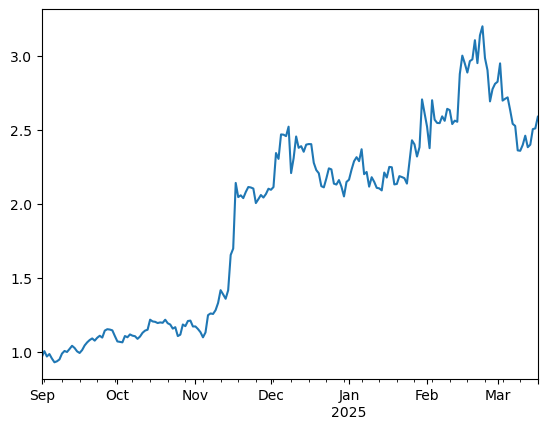

In [52]:
(1+historical_ptf['Historical Portfolio'].loc['2024-09':]).cumprod().plot()

## Ex ante data

In [54]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [57]:
days=0
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [58]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [61]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
PAXGUSDT,0.7785
OMUSDT,0.1377
AAVEUSDT,0.0350
BNBUSDT,0.0338
DEXEUSDT,0.0087
ADAUSDT,0.0062
PEPEUSDT,0.0000
TRXUSDT,0.0000
SUIUSDT,0.0000
WBTCUSDT,0.0000


In [62]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']
inventory

,Optimal Weights
PAXGUSDT,0.467502
BTCUSDT,0.300000
OMUSDT,0.232498


In [63]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))
tickers_frontier.remove('BBUSDT')

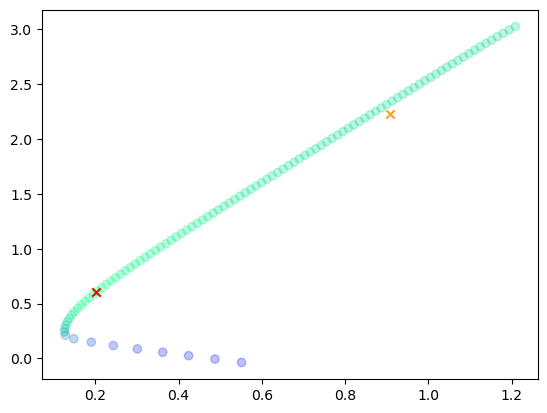

In [64]:
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

In [65]:
dico={returns_frontier.columns[i]:frontier_opt_weights[i].round(4) for i in range(len(returns_frontier.columns))}
dico=pd.DataFrame(dico.values(),index=dico.keys(),columns=['Optimal Weights'])

In [66]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,dico],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,3228.682943,0.699466,0.0636,0.635866
BTCUSDT,728.647367,0.157855,0.0000,0.157855
SOLUSDT,223.465203,0.048412,0.0000,0.048412
JASMYUSDT,171.936600,0.037249,0.0000,0.037249
ETHUSDT,132.849140,0.028781,0.0000,0.028781
TRXUSDT,114.939961,0.024901,0.0055,0.019401
BBUSDT,14.330341,0.003105,0.0000,0.003105
BNBUSDT,1.074122,0.000233,0.0671,-0.066867
PEPEUSDT,0.000002,0.000000,0.0031,-0.003100
PAXGUSDT,0.000000,0.000000,0.3985,-0.398500


### Current results

In [68]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [69]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
PAXGUSDT,0.877229
OMUSDT,0.103812
TRXUSDT,0.018960


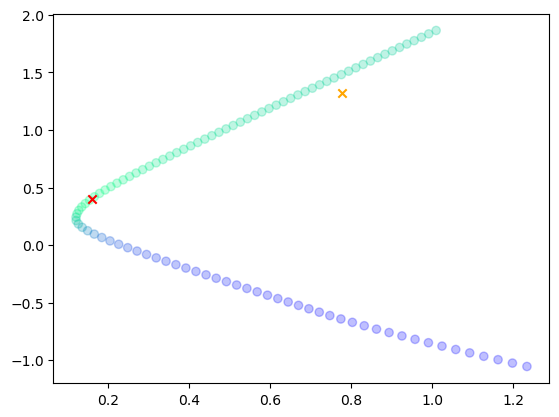

In [70]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')

In [71]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,3228.682943,0.699466,0.103812,0.595654
BTCUSDT,728.647367,0.157855,0.000000,0.157855
SOLUSDT,223.465203,0.048412,0.000000,0.048412
JASMYUSDT,171.936600,0.037249,0.000000,0.037249
ETHUSDT,132.849140,0.028781,0.000000,0.028781
TRXUSDT,114.939961,0.024901,0.018960,0.005941
BBUSDT,14.330341,0.003105,0.000000,0.003105
BNBUSDT,1.074122,0.000233,0.000000,0.000233
PEPEUSDT,0.000002,0.000000,0.000000,0.000000
PAXGUSDT,0.000000,0.000000,0.877229,-0.877229


# Risk Reward Analysis

In [73]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [74]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<Axes: >

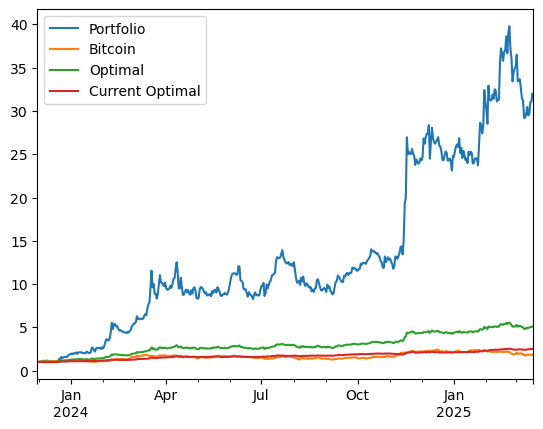

In [75]:
days=0
(1+portfolio_perf.iloc[-days:]).cumprod().plot()

In [76]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<Axes: >

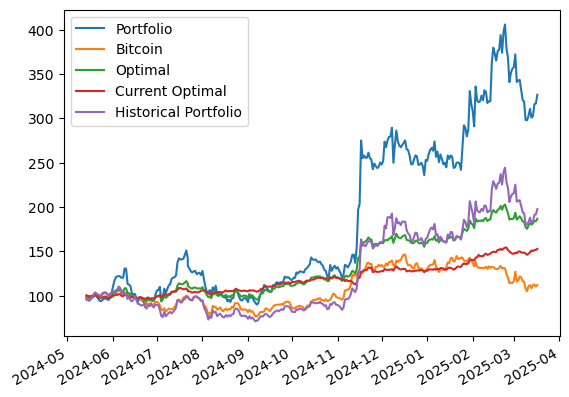

In [77]:
days=0
((1+current_perf.iloc[-days:]).cumprod()*100).plot()

In [78]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2025-03-08,318.864979,115.682157,183.321354,148.755073,193.005673
2025-03-09,298.219995,108.074181,177.194440,147.605290,180.399004
2025-03-10,297.990552,105.172891,175.432714,146.158872,180.191407
2025-03-11,302.826009,110.822138,179.226685,147.433821,183.215484
2025-03-12,310.753904,111.816046,181.716662,148.891290,187.971314
2025-03-13,300.860853,108.335893,180.263792,150.918109,182.047066
2025-03-14,302.639009,112.099402,181.556370,150.426506,183.335317
2025-03-15,316.098799,112.572571,184.357956,151.567514,191.350939
2025-03-16,316.824428,110.193184,184.030300,151.715278,191.748673
2025-03-17,326.683860,112.092354,186.775806,152.828778,197.754476


## Volatilities

In [80]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.355487
 dtype: float64,
 0.3558527386426648)

In [81]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.777767
 dtype: float64,
 0.7777670535813132)

In [82]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.907418
Bitcoin            0.433815
Optimal            0.355853
Current Optimal    0.176378
dtype: float64

In [83]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.4690606667707048

In [84]:
days=30
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

-1.752710191502707

In [85]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

1.7017336526401141

## Risk Contribution

In [87]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.248912,0.300000,0.027186,0.232273,0.133755,0.098518
OMUSDT,18.712617,0.232498,0.938294,0.722855,0.623684,0.099171
PAXGUSDT,0.229491,0.467502,0.034520,0.044872,0.028688,0.016184


In [88]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.469956,0.103812,0.328336,0.481191,0.430313,0.050878
TRXUSDT,0.007014,0.018960,0.014864,0.024360,0.008671,0.015688
PAXGUSDT,0.270531,0.877229,0.656800,0.494449,0.454122,0.040327


In [89]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,3.168892,0.70,0.933381,0.894660,0.826322,0.068337
BTCUSDT,0.028291,0.16,0.045426,0.041867,0.007368,0.034500
SOLUSDT,-0.019647,0.05,0.007323,0.023981,0.002231,0.021750
JASMYUSDT,-0.025776,0.04,0.003432,0.024911,0.003203,0.021707
ETHUSDT,-0.014129,0.03,0.003829,0.009216,0.000497,0.008719
TRXUSDT,0.007399,0.02,0.006610,0.005366,0.000408,0.004958


# Value At Risk

## Historical

### Optimal Weights

In [93]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.02847772116718002, -0.04010554227122138)

### Current Weights

In [95]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.05629769177910666, -0.08214405943169349)

In [96]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [97]:
var=historical_var.iloc[row]
var

OMUSDT      -0.044789
BTCUSDT     -0.006831
SOLUSDT     -0.001492
JASMYUSDT   -0.002165
ETHUSDT     -0.002305
TRXUSDT      0.000143
BBUSDT      -0.000000
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
PAXGUSDT    -0.000000
Portfolio   -0.057438
Name: 2024-08-04 00:00:00, dtype: float64

In [98]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.066833
BTCUSDT     -0.005744
SOLUSDT     -0.003678
JASMYUSDT   -0.003561
ETHUSDT     -0.001699
TRXUSDT     -0.000628
BBUSDT       0.000000
BNBUSDT      0.000000
PEPEUSDT     0.000000
PAXGUSDT     0.000000
Portfolio   -0.082144
dtype: float64

## Parametric

### Optimal Weights

In [101]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.03687205126253783, -0.047259775161007274)

### Current Weights

In [103]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.08058914139413303, -0.10329299760371434)

## Multivariate

### Optimal Weights

In [106]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.03297805108460802, -0.042309230519347256)

### Current Weights

In [108]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.07387825038012653, -0.09480606163542313)

In [109]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

scenario=pd.DataFrame(scenario_multivariate).T
mean_scenario_multivariate=scenario.mean()
mean_scenario_multivariate

OMUSDT      -0.067945
BTCUSDT     -0.002889
SOLUSDT     -0.001546
JASMYUSDT   -0.001795
ETHUSDT     -0.000670
TRXUSDT     -0.000339
Portfolio   -0.075184
dtype: float64

In [110]:
index_cvar=scenario['Portfolio']<mean_scenario_multivariate['Portfolio']
cvar_multivariate=scenario.loc[index_cvar].mean()
cvar_multivariate

OMUSDT      -0.067935
BTCUSDT     -0.003140
SOLUSDT     -0.001613
JASMYUSDT   -0.002142
ETHUSDT     -0.000797
TRXUSDT     -0.000391
Portfolio   -0.076018
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [114]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.033156752486357, -0.041961639833464646)

### Current Weights

In [116]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07584223736172961, -0.0953438959960267)

In [117]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results

scenario=pd.DataFrame(scenario_gaussian).T
mean_scenario_gaussian=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gaussian['Portfolio']
cvar_gaussian=scenario.loc[index_cvar].mean()

## Student Copula

### Optimal Weights

In [120]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.032592596694275985, -0.04203162971883925)

### Current Weights

In [122]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0763146920426923, -0.09837090095586674)

In [123]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
scenario=pd.DataFrame(scenario_t_copula).T
mean_scenario_student=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_student['Portfolio']
cvar_student=scenario.loc[index_cvar].mean()

## Gumbel Copula

### Optimal Weights

In [126]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06922149336654497, -0.09634759210879289)

### Current Weights

In [128]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.1599071317172953, -0.22601745736638254)

In [129]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    

scenario=pd.DataFrame(scenario_gumbel_copula).T
mean_scenario_gumbel=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gumbel['Portfolio']
cvar_gumbel=scenario.loc[index_cvar].mean()

## Monte Carlo

### Optimal

In [132]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [133]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.03808691808508858, -0.0472888431325277)

### Current Weights

In [135]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.08049445528296677, -0.10087224565185156)

In [136]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results

scenario=pd.DataFrame(scenario_monte_carlo).T
mean_scenario_monte_carlo=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_monte_carlo['Portfolio']
cvar_monte_carlo=scenario.loc[index_cvar].mean()

In [137]:
summary_var=pd.concat([mean_scenario_gumbel,mean_scenario_gaussian,mean_scenario_monte_carlo,mean_scenario_multivariate,mean_scenario_student],axis=1)
summary_var.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_var

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
OMUSDT,-0.157570,-0.067693,-0.074015,-0.067945,-0.068604
BTCUSDT,-0.000191,-0.002736,-0.003468,-0.002889,-0.002537
SOLUSDT,-0.000349,-0.001750,-0.001841,-0.001546,-0.001777
JASMYUSDT,-0.000330,-0.001873,-0.001806,-0.001795,-0.002371
ETHUSDT,0.000257,-0.000689,-0.000754,-0.000670,-0.000679
TRXUSDT,0.000150,-0.000428,-0.000351,-0.000339,-0.000541
Portfolio,-0.158033,-0.075169,-0.082235,-0.075184,-0.076509


In [138]:
summary_cvar=pd.concat([cvar_gumbel,cvar_gaussian,cvar_monte_carlo,cvar_multivariate,cvar_student],axis=1)
summary_cvar.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_cvar

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
OMUSDT,-0.159020,-0.068378,-0.074361,-0.067935,-0.069023
BTCUSDT,-0.001063,-0.002744,-0.003950,-0.003140,-0.002587
SOLUSDT,-0.000027,-0.001579,-0.002017,-0.001613,-0.001921
JASMYUSDT,-0.000960,-0.001998,-0.001522,-0.002142,-0.002434
ETHUSDT,0.000516,-0.000625,-0.000721,-0.000797,-0.000759
TRXUSDT,-0.000013,-0.000577,-0.000445,-0.000391,-0.000697
Portfolio,-0.160567,-0.075900,-0.083016,-0.076018,-0.077421


## VaR Violation

In [140]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.028958,-0.054327,-0.048148,-0.011875
2024-01-15,-0.028958,-0.054332,-0.046618,0.012409
2024-01-16,-0.028958,-0.054392,-0.045021,0.025054
2024-01-17,-0.028958,-0.055774,-0.047802,-0.019907
2024-01-18,-0.028958,-0.056674,-0.051029,-0.015632
...,...,...,...,...
2025-03-14,-0.038915,-0.046467,-0.047339,0.007170
2025-03-15,-0.038915,-0.046957,-0.046865,0.015431
2025-03-16,-0.038915,-0.043448,-0.045405,-0.001777
2025-03-17,-0.038915,-0.043396,-0.044976,0.014919


In [141]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.045379,-0.084160,-0.084199,-0.015006
2024-05-29,-0.045379,-0.082059,-0.080217,-0.007208
2024-05-30,-0.045379,-0.072331,-0.073132,0.025761
2024-05-31,-0.045379,-0.076553,-0.073395,0.049656
2024-06-01,-0.045379,-0.083514,-0.079172,0.067499
...,...,...,...,...
2025-03-14,-0.081193,-0.078726,-0.090017,0.005910
2025-03-15,-0.081193,-0.084282,-0.092265,0.044475
2025-03-16,-0.081193,-0.084114,-0.094025,0.002296
2025-03-17,-0.081193,-0.082356,-0.091523,0.031120


<Axes: >

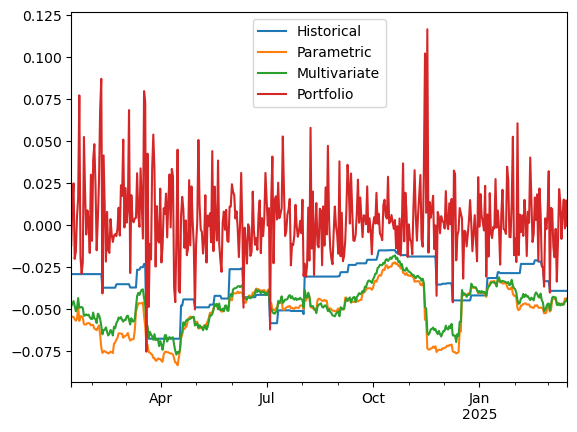

In [142]:
var_data.plot()

<Axes: >

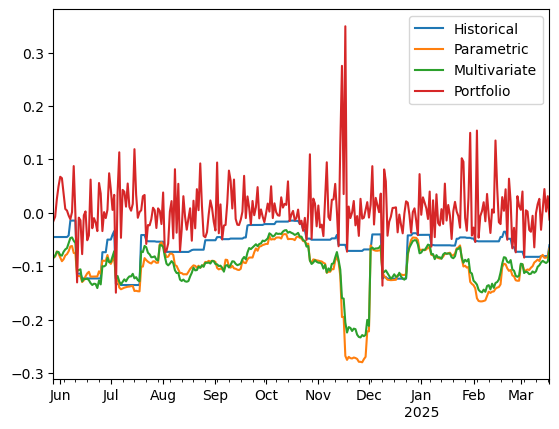

In [143]:
current_var_data.plot()

In [144]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.032558,0.006977,0.006977
Kupiec Stat,3.124987,26.008809,26.008809
P-value,0.0771,0.0,0.0


In [145]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.064407,0.010169,0.010169
Kupiec Stat,1.186224,14.430112,14.430112
P-value,0.276093,0.000145,0.000145


# Principal Component Analysis

## Historical PCA

In [148]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.81185346, 0.05659943, 0.04975099, 0.04665425, 0.03514187])

In [149]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT     0.017610
ADAUSDT      0.019006
ALGOUSDT     0.020042
APTUSDT      0.017732
ARBUSDT      0.019357
ATOMUSDT     0.017531
AVAXUSDT     0.019533
BCHUSDT      0.015597
BNBUSDT      0.009158
BONKUSDT     0.024002
BTCUSDT      0.009889
CAKEUSDT     0.018387
DEXEUSDT     0.013648
DOGEUSDT     0.018816
DOTUSDT      0.018058
EOSUSDT      0.018327
ETCUSDT      0.016407
ETHUSDT      0.013493
FDUSDUSDT    0.000051
FETUSDT      0.023005
FILUSDT      0.019868
FLOWUSDT     0.019276
GALAUSDT     0.023451
GRTUSDT      0.021639
HBARUSDT     0.018954
ICPUSDT      0.017866
IMXUSDT      0.019980
INJUSDT      0.020992
IOTAUSDT     0.021271
JASMYUSDT    0.021302
LDOUSDT      0.020672
LINKUSDT     0.017822
LTCUSDT      0.013345
MKRUSDT      0.013097
NEARUSDT     0.021586
NEXOUSDT     0.011556
OMUSDT       0.010946
OPUSDT       0.019891
PAXGUSDT     0.000260
PEPEUSDT     0.024526
QNTUSDT      0.015578
SANDUSDT     0.021536
SEIUSDT      0.021275
SHIBUSDT     0.018386
SOLUSDT      0.016468
STXUSDT   

<Axes: >

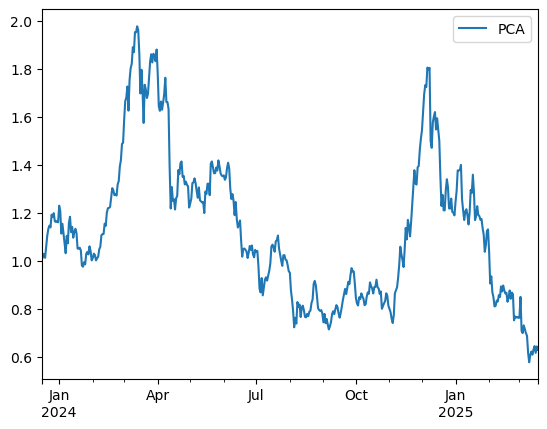

In [150]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()

<Axes: >

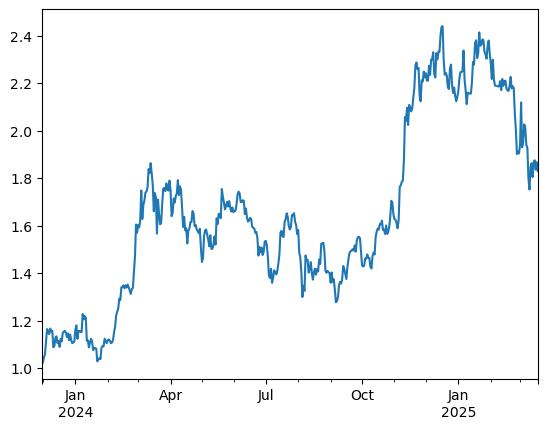

In [151]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [152]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
FLOWUSDT     0.426260
WBETHUSDT    0.461603
ETHUSDT      0.462009
ATOMUSDT     0.474521
DOTUSDT      0.477591
ETCUSDT      0.490105
NEXOUSDT     0.514304
EOSUSDT      0.529823
AVAXUSDT     0.547972
BTCUSDT      0.550785
WBTCUSDT     0.550823
FILUSDT      0.565877
IOTAUSDT     0.567213
ARBUSDT      0.580677
GRTUSDT      0.582266
XTZUSDT      0.583076
LINKUSDT     0.609488
VETUSDT      0.612142
IMXUSDT      0.623215
dtype: float64

<Axes: >

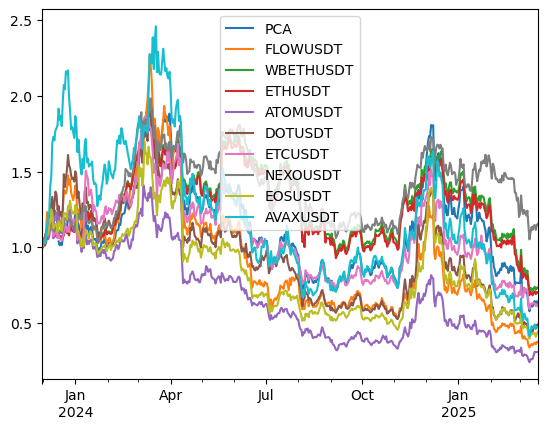

In [153]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<Axes: >

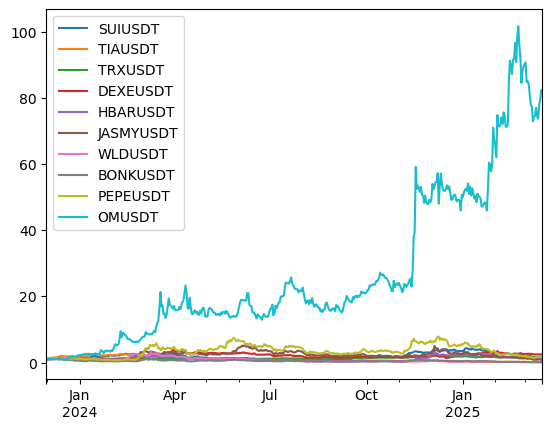

In [154]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [156]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.59680348, 0.14075406, 0.10917438, 0.08836742, 0.06490067])

In [157]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.088346
BTCUSDT      0.061211
SOLUSDT      0.108095
JASMYUSDT    0.172677
ETHUSDT      0.089038
TRXUSDT      0.050959
BBUSDT       0.197870
BNBUSDT      0.065745
PEPEUSDT     0.163199
PAXGUSDT     0.002859
Name: PC1, dtype: float64

<Axes: >

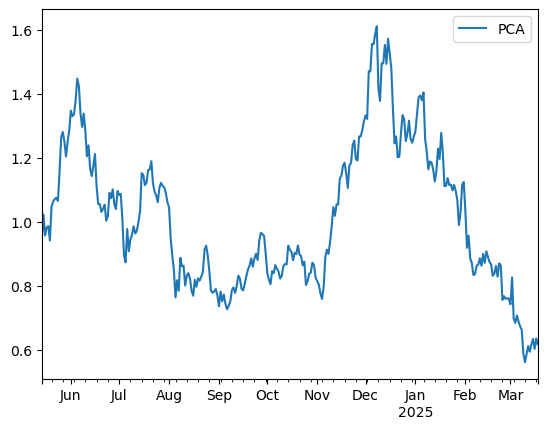

In [158]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<Axes: >

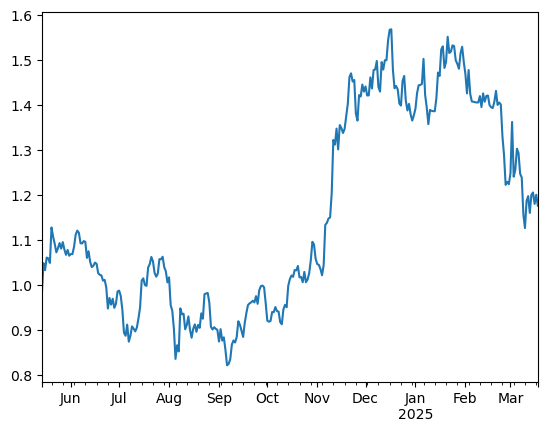

In [159]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [160]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\niroo\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
ETHUSDT      0.450153
BNBUSDT      0.506949
BTCUSDT      0.515389
SOLUSDT      0.526964
JASMYUSDT    0.707038
PEPEUSDT     0.761121
PAXGUSDT     0.782199
BBUSDT       0.807155
TRXUSDT      0.950000
dtype: float64

<Axes: >

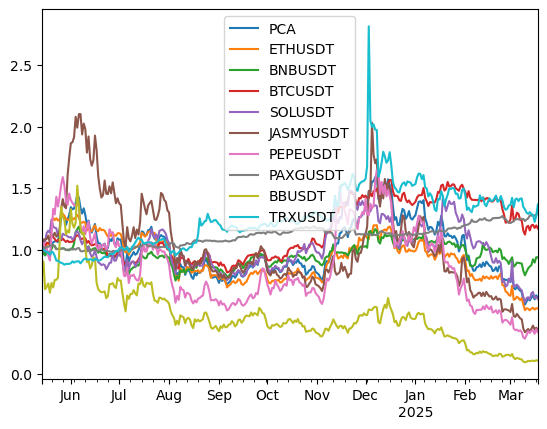

In [161]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [163]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.882417
BBUSDT       1.580031
JASMYUSDT    1.379862
SOLUSDT      1.240574
ETHUSDT      1.012048
BTCUSDT      1.000000
OMUSDT       0.875490
BNBUSDT      0.669135
TRXUSDT      0.338481
PAXGUSDT     0.037254
Name: BTCUSDT, dtype: float64

In [164]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

SOLUSDT      1.842312
PEPEUSDT     1.651373
JASMYUSDT    1.589847
BBUSDT       1.375170
ETHUSDT      1.303648
BTCUSDT      1.000000
BNBUSDT      0.678018
OMUSDT       0.634088
TRXUSDT      0.406342
PAXGUSDT     0.026149
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [166]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [167]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
BNBUSDT,0.233191
ETHUSDT,0.204032
BTCUSDT,0.180044
BBUSDT,0.164253
JASMYUSDT,0.138102
SOLUSDT,0.096673
PEPEUSDT,0.077259
TRXUSDT,0.070863
OMUSDT,-0.069727
PAXGUSDT,-0.258327


### Regression to PCA

In [169]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

1.0455356266774187

In [170]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.298622
BNBUSDT      1.163160
ETHUSDT      1.000317
PCA          1.000000
PAXGUSDT     0.738986
SOLUSDT      0.709285
JASMYUSDT    0.471215
PEPEUSDT     0.438375
BBUSDT       0.408861
TRXUSDT      0.284265
OMUSDT       0.249954
dtype: float64

In [171]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BNBUSDT      1.412148
BTCUSDT      1.338683
PCA          1.000000
ETHUSDT      0.956253
TRXUSDT      0.938668
JASMYUSDT    0.776286
BBUSDT       0.677151
SOLUSDT      0.644588
PEPEUSDT     0.641126
OMUSDT       0.637594
PAXGUSDT    -0.123233
dtype: float64

### Correlation Matrix

<Axes: >

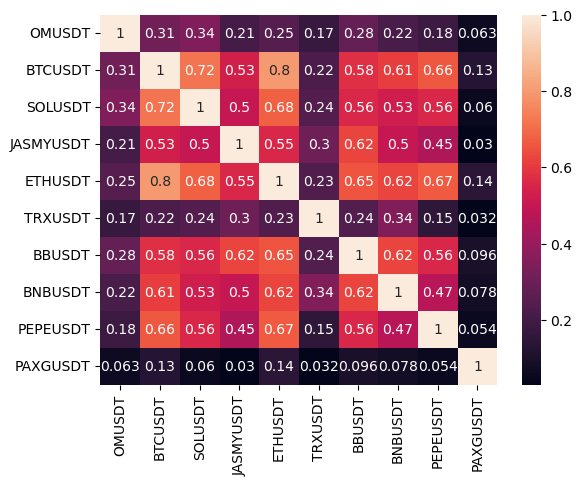

In [173]:
sns.heatmap(ex_ante_perf.corr(),annot=True)

<Axes: >

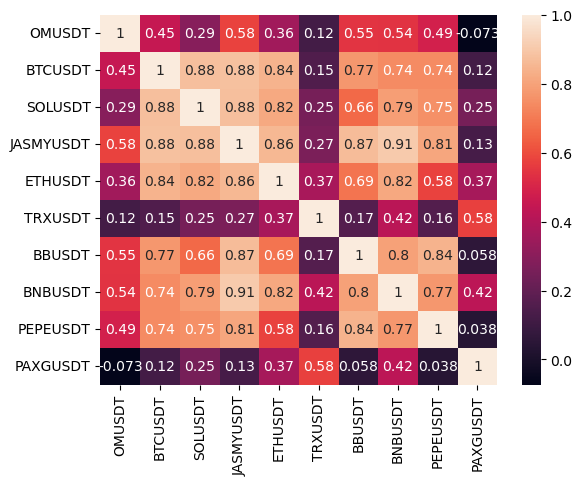

In [174]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

## Sliding window optimization

In [176]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,SOLUSDT,JASMYUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT,PAXGUSDT
2024-05-27,0.000000,0.000000,0.000000,0.483879,0.000000,0.000000,0.000000,0.000000,0.301117,0.215004
2024-06-10,0.626168,0.000000,0.000000,0.150876,0.000000,0.222957,0.000000,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.932091,0.000000,0.000000,0.000000,0.067909
2024-07-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.223616,0.003604,0.000000,0.000000,0.772780
2024-07-22,0.019283,0.260704,0.086231,0.000000,0.000000,0.238042,0.000000,0.000000,0.000000,0.395740
2024-08-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.453780,0.000000,0.000000,0.000000,0.546220
2024-09-02,0.435186,0.000000,0.000000,0.000000,0.000000,0.564814,0.000000,0.000000,0.000000,0.000000
2024-09-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-09-30,0.176734,0.000000,0.000000,0.000000,0.166022,0.526886,0.000000,0.000000,0.130357,0.000000


In [177]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ATOMUSDT,AVAXUSDT,BCHUSDT,BNBUSDT,BONKUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-08-10,0.00000,0.002012,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.802984,0.0
2024-09-09,0.05306,0.007964,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.135553,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2024-10-09,0.00000,0.002012,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.320535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2024-11-08,0.00000,0.008643,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2024-12-08,0.00000,0.002012,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.223762,0.0
2025-01-07,0.00000,0.002012,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2025-02-06,0.00000,0.002012,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2025-03-08,0.00000,0.092123,0.0,0.0,0.0,0.0,0.0,0.261892,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2025-03-18,0.00000,0.002012,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [178]:
rolling_optimization.iloc[-1].sort_values(ascending=False)[:6]

PAXGUSDT    0.875674
OMUSDT      0.096581
CAKEUSDT    0.025733
ADAUSDT     0.002012
SOLUSDT     0.000000
LTCUSDT     0.000000
Name: 2025-03-18 00:00:00, dtype: float64

In [195]:
create_or_replace_notebook("Prod.ipynb", repo_owner, repo_name, token)

File 'RSI Strategy.ipynb' does not exist. Creating new file...
✅ File 'RSI Strategy.ipynb' successfully pushed/updated to GitHub!
